## Data Preparation

### Imports

Packages that need to be imported:



In [1]:
import pandas as pd
import json
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

### Read dataframe

Read json file with words and the list of videos:

In [2]:
url = "https://raw.githubusercontent.com/dxli94/WLASL/master/start_kit/WLASL_v0.3.json"
df = pd.read_json(url)
df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [3]:
#Export a list of words in csv
#df["gloss"].to_csv("list_words.csv")

### Filter df only selected words

Filter the json file with words that will be used to train our model. This file will be used later to download the videos.

In [4]:
list_selected_words = ["headache", "cough", "sore throat", "blood", "pregnant", "diabetes", 
                       "stomach","pain", "allergy", "cold", "bone","diarrhea", "heart", "heart attack", 
                       "cochlear implant", "vomit", "depressed", "hurt", "infection", "tired", "thank you"]

df = df[df['gloss'].isin(list_selected_words)]
df.head()

,gloss,instances
117,headache,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
147,cold,"[{'bbox': [129, 16, 476, 370], 'fps': 25, 'fra..."
175,tired,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
269,cough,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
287,heart,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [5]:
print(f"Df shape: {df.shape}")

Df shape: (21, 2)


### Export pandas df to json file

In [6]:
#new_json = df.to_json("WLASL_v0.3.json", orient='records')

### Explore instances

Create a dataframe with video_ids and the corresponding word. Notice that in this step we are using the json file exported in the previous step, which contains information about only 21 words.

In [7]:
content = json.load(open("../scripts/WLASL_v0.3.json"))

id_videos = []
for entry in content:
    word = entry["gloss"]
    instances = entry['instances']

    for inst in instances:
        video_id = inst['video_id']
        id_videos.append([word, video_id])

In [8]:
id_list = pd.DataFrame(id_videos, columns=["word", "video_id"])
id_list.head()

,word,video_id
0,headache,26832
1,headache,26835
2,headache,26836
3,headache,26837
4,headache,26838


Because of problems during download, we were not able to download all video_ids. To count the real number of videos that we have available, we need to check if they are in our folder.

In [9]:
ids_in_folder = []

for video_id in id_list.video_id:
    if os.path.exists(f'../raw_data/{video_id}.mp4'):
        ids_in_folder.append(video_id)

print(f"Number os videos: {len(ids_in_folder)}")

Number os videos: 154


Filter dataframe to only videos available in our folder:

In [10]:
id_list = id_list[id_list['video_id'].isin(ids_in_folder)]
print(f"Shape new df: {id_list.shape}")

Shape new df: (154, 2)


#### Count videos per symptoms
Check how many videos we have, by symptom, to train our model.

In [11]:
aux_list = id_list.groupby("word").count().reset_index()
aux_list.sort_values("video_id")

,word,video_id
2,bone,4
1,blood,5
14,pain,6
18,thank you,6
13,infection,6
6,depressed,6
7,diabetes,6
15,pregnant,6
11,heart attack,6
0,allergy,7


## Setup Preparation

### Setup Folder

In [12]:
# # Path for exported data, numpy arrays
# DATA_PATH = os.path.join('../MP_Data') 

# # Videos are going to be 70 frames in length
# sequence_length = 70 #wont be used anymore

In [13]:
# # ----------------------------------------------------
# # Loop to create folders for each action to be trained
# # and n_folder depending on the number of videos
# # ----------------------------------------------------

# for word in range(0, len(aux_list.word)):   # modificar range depois dos testes (0, len..)
    
#     # Identify how many videos per action
#     n_folders = aux_list.iloc[word, 1]
    
#     # Create folders
#     for n in range(n_folders):
#         try:
#             folder = os.path.join(DATA_PATH, aux_list.iloc[word, 0], str(n))
#             os.makedirs(folder)
#         except:
#             pass

### Functions for data detection

In [14]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [15]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [16]:
mediapipe_detection

<function __main__.mediapipe_detection(image, model)>

In [17]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [18]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [19]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## Length Histogram

### To check lenght of videos

In [20]:
# Function to extract video id for selected word - Giovanna 
def videos_word(word):
  
    id_list_novo = id_list[id_list['word'] == word]
    lista_videos = [video_id for video_id in id_list_novo.video_id]
    
    return lista_videos

In [21]:
# Function to return duration and framecount for each video
def with_opencv(filename):
    import cv2
    video = cv2.VideoCapture(filename)

    duration = video.get(cv2.CAP_PROP_POS_MSEC)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

    return duration, frame_count



# Get id_videos from function video_words and return lenght
n_frames = []
teste = []

for word in aux_list["word"]:
    for video_id in videos_word(word):
        video = f'../raw_data/{video_id}.mp4'
        frame_count = with_opencv(video)[1]
        n_frames.append(frame_count)
        teste.append([word, video_id, frame_count])
        
frames_words = pd.DataFrame(teste, columns=["action", "video_id", "frames"])
frames_words

,action,video_id,frames
0,allergy,01962,54.0
1,allergy,01955,119.0
2,allergy,01965,106.0
3,allergy,01956,40.0
4,allergy,01957,108.0
...,...,...,...
149,vomit,61987,30.0
150,vomit,61990,98.0
151,vomit,61978,115.0
152,vomit,61979,84.0


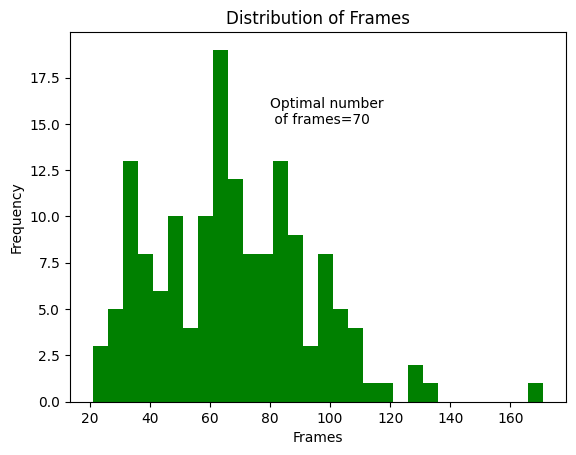

In [22]:
# Plot distribution frames 
plt.title("Distribution of Frames")
plt.xlabel('Frames')
plt.ylabel('Frequency')
plt.hist(pd.DataFrame(n_frames), bins=30, color="g", stacked=True);
plt.text(80, 15, f'Optimal number \n of frames=70');

In [23]:
# Function to retrieve words, video, frames

def words_video(word):
    w = frames_words[frames_words['action'] == word].reset_index()
    return w


In [24]:
words_video("cochlear implant")

,index,action,video_id,frames
0,16,cochlear implant,65373,57.0
1,17,cochlear implant,11498,98.0
2,18,cochlear implant,11499,33.0
3,19,cochlear implant,11500,32.0
4,20,cochlear implant,11501,128.0
5,21,cochlear implant,11502,65.0
6,22,cochlear implant,11503,33.0
7,23,cochlear implant,11504,50.0


## Data Points - New

#### Model Plan A - with loop

In [25]:
# ---------------------------------------------------
# Function to extract data points
# Action = word
# Folder = /word/number_folder
# Video_id = name of the video
# ---------------------------------------------------


def extract_datapoints(action, folder, video_id, frames):
    
    data_path = os.path.join('../MP_Data')
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        for frame_num in range(frames):

                    # Read feed
                    ret, frame = cap.read()

                    # Make detections
                    try:
                        image, results = mediapipe_detection(frame, holistic)
                        print(results)

                        # Draw landmarks and text
                        draw_styled_landmarks(image, results)
                        cv2.putText(image, 'Frames for {} video {}'.format(action, folder), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 255), 1, cv2.LINE_AA)

                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(500)

                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(data_path, action, folder, str(frame_num))
                        np.save(npy_path, keypoints)

                        # Break gracefully
                        if cv2.waitKey(10) & 0xFF == ord('q'):
                            break
                    except:
                        pass

In [26]:
# # ---------------------------------------------------
# # Loop to extract data points using function
# # ---------------------------------------------------

# selected_word = ["pregnant"]

# for word in selected_word:
            
#     # Filter the dataframe
#     df_temp = frames_words[frames_words["action"] == word] 

#     # Get information for each action
#     for word in range(0, len(df_temp.action)):

#         action = df_temp.iloc[word, 0]
#         cap = cv2.VideoCapture(f"../raw_data/{df_temp.iloc[word, 1]}.mp4")
#         sequence_folder = word
#         frames = [int(df_temp.iloc[word, 2]) if int(df_temp.iloc[word, 2]) < 70 else 70][0]

#         # Call the function to extract data points
#         extract_datapoints(action, str(sequence_folder), cap, frames)

#### Model  - Plan B 

### Np array comparison

In [27]:
# Sem loop
for i in range(0, 25):
    print(np.load(f"../MP_Data/stomach/4/{i}.npy"))

[ 0.57193285  0.22017854 -1.21904743 ...  0.56454998  0.98780501
 -0.04535049]
[ 0.57182086  0.22017053 -1.21666038 ...  0.56297451  0.98693269
 -0.04896437]
[ 0.56920975  0.22020189 -1.22161901 ...  0.56155217  0.98782045
 -0.05091175]
[ 0.56656766  0.22038238 -1.24134922 ...  0.56062192  0.9881565
 -0.04992827]
[ 0.56610423  0.22070996 -1.25370991 ...  0.56032741  0.98862565
 -0.04985459]
[ 0.56602693  0.22074513 -1.27188563 ...  0.56094748  0.98994315
 -0.04982345]
[ 0.56592685  0.22074993 -1.27112269 ...  0.56134677  0.98916227
 -0.04781786]
[ 0.56554478  0.22077982 -1.27350807 ...  0.5613519   0.98848212
 -0.04608831]
[ 0.5652917   0.22078179 -1.26475048 ...  0.56149757  0.98836863
 -0.04495885]
[ 0.56501824  0.22064899 -1.23950505 ...  0.56173271  0.98637193
 -0.04471043]
[ 0.5646292   0.22006194 -1.23444712 ...  0.56119829  0.98530853
 -0.04455883]
[ 0.56444931  0.21886954 -1.19446301 ...  0.56069505  0.98476136
 -0.04449674]
[ 0.56355226  0.21670197 -1.2592721  ...  0.55945921 

In [28]:
# # Com loop
# for i in range(5, 15):
#     print(np.load(f"../MP_Data/teste/1/{i}.npy"))

## Extract Data Points - Old

### Extract data points from videos

In [29]:
# # ---------------------------------------------------
# #  Function to extract data points from videos
# #  Action = words
# #  Video_id = name of the video
# #  Sequence = folder in which it will be placed
# # ---------------------------------------------------

# def extract_data_points(action, video_id, folder):
    
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

#         for frame_num in range(sequence_length):
            
#             sequence = 1

#             # Read feed
#             cap = cv2.VideoCapture(f'../raw_data/{video_id}.mp4')
#             ret, frame = cap.read()

#             # Make detections
#             image, results = mediapipe_detection(frame, holistic)
#             print(results)

#             # Draw landmarks
#             draw_styled_landmarks(image, results)

#             # Apply wait logic
#             if frame_num == 0: 
#                 cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)
#                 cv2.waitKey(2000)
#             else: 
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)

#             # Export keypoints
#             keypoints = extract_keypoints(results)
#             npy_path = os.path.join(DATA_PATH, action, str(folder), str(frame_num))
#             np.save(npy_path, keypoints)

#             # Break gracefully
#             if cv2.waitKey(10) & 0xFF == ord('q'):
#                 break

In [30]:
# # ---------------------------------------------------
# # Loop to extract data points for each word and video
# # and save it in the correct folder
# # ---------------------------------------------------

# for word in id_list.word.unique():
    
#     if word == "tired": #apagar depois dos testes, filtra apenas 1 palavra
        
#         # Filter the dataframe
#         df_temp = id_list[id_list["word"] == word] 

#         # Get information for each action
#         for word in range(0, len(df_temp.word)):

#             action = df_temp.iloc[word, 0]
#             video_id = df_temp.iloc[word, 1]
#             sequence = word

#             # Call the function to extract data points
#             extract_data_points(action, video_id, sequence)

### Extract data points from webcam

## Preprocess Data and Create Labels and Features

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [32]:
actions = np.array(aux_list.word.tolist())

actions

array(['allergy', 'blood', 'bone', 'cochlear implant', 'cold', 'cough',
       'depressed', 'diabetes', 'diarrhea', 'headache', 'heart',
       'heart attack', 'hurt', 'infection', 'pain', 'pregnant',
       'sore throat', 'stomach', 'thank you', 'tired', 'vomit'],
      dtype='<U16')

In [34]:
label_map = {label:num for num, label in enumerate(actions)}


In [35]:
label_map

{'allergy': 0,
 'blood': 1,
 'bone': 2,
 'cochlear implant': 3,
 'cold': 4,
 'cough': 5,
 'depressed': 6,
 'diabetes': 7,
 'diarrhea': 8,
 'headache': 9,
 'heart': 10,
 'heart attack': 11,
 'hurt': 12,
 'infection': 13,
 'pain': 14,
 'pregnant': 15,
 'sore throat': 16,
 'stomach': 17,
 'thank you': 18,
 'tired': 19,
 'vomit': 20}

In [35]:
# no_videos = 3
# seq_lenght_test = 30

In [36]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data/bone/0/3.npy')

array([ 0.53550684,  0.34136209, -0.61989337, ...,  0.        ,
        0.        ,  0.        ])

In [37]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data/bone/3/3.npy')

array([ 0.4734031 ,  0.31705609, -0.72957027, ...,  0.        ,
        0.        ,  0.        ])

In [38]:
aux_list.video_id

0      7
1      5
2      4
3      8
4     13
5      8
6      6
7      6
8      7
9     10
10    10
11     6
12     7
13     6
14     6
15     6
16     7
17     8
18     6
19     8
20    10
Name: video_id, dtype: int64

In [19]:
len(actions[0])

7

In [20]:
pwd

'/Users/pr/code/pariosur/sign-language-translator/notebooks'

In [ ]:
actions

In [107]:
# sequences = []

# for action in actions:
#     num_videos = len(os.listdir(f'../MP_Data/{action}'))-1
    
#     for video in range(num_videos):
#         window = []
#         num_of_frame = len(os.listdir(f'../MP_Data/{action}/{video}'))-1
#         # video_array = np.load('../MP_Data/bone/0/3.npy') 
        
#         for frame_num in range(num_of_frame):
#             frame_array = np.load(f'../MP_Data/{action}/{video}/{frame_num}.npy')
#             window.append(frame_array)
            
#         sequences.append(window)
        

Code to create X,Y with Julien

In [58]:
# sequences, labels = [],[]

# for action in actions:
#     num_videos = len(os.listdir(f'../MP_Data/{action}'))-1

#     for video in range(num_videos):
#         num_of_frame = len(os.listdir(f'../MP_Data/{action}/{video}'))-1
#         window = []
        
#         for frame_num in range(num_of_frame):
#             res = np.load(f'../MP_Data/{action}/{video}/{frame_num}.npy')
#             window.append(res)
#         sequences.append(window)
#         labels.append(label_map[action])

Check the number of videos

In [38]:
# -----------------------------
# Function to extract path 
# from files to import. Returns
# a list with path
# -----------------------------

def path_files(word, n_videos):
    
    all_files = []
    
    path = "../MP_Data/"
    for n in range(int(n_videos)):
        
        single_videos = []
        
        temp_path = os.path.join(path, word, str(n))
        list_files = os.listdir(temp_path)
        
        for file in list_files:
            file_path = os.path.join(path, word, str(n), file)
            single_videos.append(file_path)
            
        all_files.append(single_videos)
        
    return all_files

In [39]:
# -----------------------------
# Save in a dictionary the name 
# of action and all the files to
# import
# -----------------------------

action_files = {}

for line in range(len(aux_list)):
    action = aux_list.iloc[line, 0]
    n_videos = aux_list.iloc[line, 1]
    
    action_files[action] = path_files(action, n_videos)

In [40]:
sequences, labels = [] , []

for action in action_files.keys():
    
    for file in action_files[action]:
        
        window = []
        
        for path in file:
         
            # Append X
            array = np.load(path)
            window.append(array)
    
        sequences.append(window)
        
        # Append y
        labels.append(label_map.get(action))

In [41]:
len(np.array(sequences))

/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/ipykernel_25391/593582782.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  len(np.array(sequences))


154

BREAK

In [42]:
np.load('../MP_Data/bone/0/3.npy')

array([ 0.53550684,  0.34136209, -0.61989337, ...,  0.        ,
        0.        ,  0.        ])

In [43]:
np.array(sequences).shape

/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/ipykernel_25391/1188987122.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sequences).shape


(154,)

In [44]:
np.array(labels).shape

(154,)

In [45]:
X = np.array(sequences)

/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/ipykernel_25391/2138012482.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(sequences)


In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
X_pad = pad_sequences(X, dtype='float32',padding='post',maxlen=100, value=-1000)

In [50]:
X_pad.shape

(154, 100, 1662)

In [51]:
X_pad[0]

array([[ 4.5711082e-01,  2.8485426e-01, -6.5528876e-01, ...,
         4.2869151e-01,  3.9285198e-01, -8.1399567e-03],
       [ 4.8190647e-01,  2.8488854e-01, -4.9601805e-01, ...,
         3.5632646e-01,  4.8288813e-01, -2.2695957e-02],
       [ 4.8083374e-01,  2.8177437e-01, -4.1960186e-01, ...,
         3.2050031e-01,  4.8421961e-01, -2.5204767e-02],
       ...,
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03],
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03],
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03]], dtype=float32)

In [56]:
y = to_categorical(labels).astype(int)


In [57]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.20)


In [59]:
X_train.shape

(123, 100, 1662)

In [60]:
y_test.shape


(31, 21)

## Build and Train LSTM Neural Network

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

2022-09-02 11:23:48.096872: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-02 11:23:48.096964: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-02 11:23:48.099068: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Model 1

In [63]:
model = Sequential()
model.add(Masking(mask_value=-1000))
model.add(GRU(32, return_sequences=False, activation='relu', input_shape=(100,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

2022-09-02 11:23:49.190522: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model 2

In [65]:
model = Sequential()
model.add(Masking(mask_value=-1000))
model.add(GRU(32, return_sequences=False, activation='relu', input_shape=(100,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [66]:
actions.shape[0]

21

In [67]:
res = [.7, 0.2, 0.1]
res

[0.7, 0.2, 0.1]

In [68]:
actions[np.argmax(res)]


'allergy'

In [69]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [70]:
es = EarlyStopping(patience=500, restore_best_weights=True)
model.fit(X_train, y_train, epochs=2000, callbacks=[es], validation_split = 0.3, batch_size = 16)


2022-09-02 11:24:11.556990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000
6/6 [==============================] - 1s 70ms/step - loss: 3.1440 - categorical_accuracy: 0.0116 - val_loss: 3.0288 - val_categorical_accuracy: 0.0811
Epoch 2/2000
6/6 [==============================] - 0s 37ms/step - loss: 3.0468 - categorical_accuracy: 0.0581 - val_loss: 3.0683 - val_categorical_accuracy: 0.0541
Epoch 3/2000
6/6 [==============================] - 0s 36ms/step - loss: 3.0425 - categorical_accuracy: 0.0698 - val_loss: 3.0278 - val_categorical_accuracy: 0.1351
Epoch 4/2000
6/6 [==============================] - 0s 36ms/step - loss: 3.0752 - categorical_accuracy: 0.0465 - val_loss: 3.0812 - val_categorical_accuracy: 0.0270
Epoch 5/2000
6/6 [==============================] - 0s 35ms/step - loss: 3.0372 - categorical_accuracy: 0.0581 - val_loss: 3.0772 - val_categorical_accuracy: 0.0270
Epoch 6/2000
6/6 [==============================] - 0s 36ms/step - loss: 3.0470 - categorical_accuracy: 0.0698 - val_loss: 3.0563 - val_categorical_accuracy: 0.0270
Epoch 7/20

6/6 [==============================] - 0s 38ms/step - loss: 2.5881 - categorical_accuracy: 0.1279 - val_loss: 2.9850 - val_categorical_accuracy: 0.1081
Epoch 51/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.5573 - categorical_accuracy: 0.1279 - val_loss: 3.0659 - val_categorical_accuracy: 0.0541
Epoch 52/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.5726 - categorical_accuracy: 0.1279 - val_loss: 3.0297 - val_categorical_accuracy: 0.0811
Epoch 53/2000
6/6 [==============================] - 0s 36ms/step - loss: 2.5334 - categorical_accuracy: 0.1512 - val_loss: 3.2967 - val_categorical_accuracy: 0.0541
Epoch 54/2000
6/6 [==============================] - 0s 37ms/step - loss: 2.6112 - categorical_accuracy: 0.1163 - val_loss: 2.9846 - val_categorical_accuracy: 0.0811
Epoch 55/2000
6/6 [==============================] - 0s 36ms/step - loss: 2.5199 - categorical_accuracy: 0.1628 - val_loss: 2.9674 - val_categorical_accuracy: 0.0541
Epoch 56/2000
6/6 

6/6 [==============================] - 0s 44ms/step - loss: 2.1651 - categorical_accuracy: 0.2907 - val_loss: 3.2234 - val_categorical_accuracy: 0.0811
Epoch 100/2000
6/6 [==============================] - 0s 37ms/step - loss: 2.1666 - categorical_accuracy: 0.2558 - val_loss: 3.5598 - val_categorical_accuracy: 0.0000e+00
Epoch 101/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.2688 - categorical_accuracy: 0.2442 - val_loss: 3.1930 - val_categorical_accuracy: 0.0541
Epoch 102/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.1250 - categorical_accuracy: 0.3140 - val_loss: 3.4278 - val_categorical_accuracy: 0.0000e+00
Epoch 103/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.1629 - categorical_accuracy: 0.2907 - val_loss: 3.4585 - val_categorical_accuracy: 0.0000e+00
Epoch 104/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.1102 - categorical_accuracy: 0.2674 - val_loss: 3.3209 - val_categorical_accuracy: 0.0541
E

6/6 [==============================] - 0s 36ms/step - loss: 1.7627 - categorical_accuracy: 0.4186 - val_loss: 3.5435 - val_categorical_accuracy: 0.1622
Epoch 149/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.7826 - categorical_accuracy: 0.4651 - val_loss: 3.8056 - val_categorical_accuracy: 0.0811
Epoch 150/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.7399 - categorical_accuracy: 0.4186 - val_loss: 3.5678 - val_categorical_accuracy: 0.1081
Epoch 151/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.7668 - categorical_accuracy: 0.3837 - val_loss: 3.7330 - val_categorical_accuracy: 0.0541
Epoch 152/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.8264 - categorical_accuracy: 0.4070 - val_loss: 4.3031 - val_categorical_accuracy: 0.1081
Epoch 153/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.8308 - categorical_accuracy: 0.3721 - val_loss: 3.6545 - val_categorical_accuracy: 0.1622
Epoch 154/200

6/6 [==============================] - 0s 38ms/step - loss: 1.6233 - categorical_accuracy: 0.4535 - val_loss: 5.2217 - val_categorical_accuracy: 0.0541
Epoch 198/2000
6/6 [==============================] - 0s 38ms/step - loss: 1.7942 - categorical_accuracy: 0.3837 - val_loss: 5.2085 - val_categorical_accuracy: 0.1351
Epoch 199/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.4848 - categorical_accuracy: 0.5349 - val_loss: 4.5281 - val_categorical_accuracy: 0.0811
Epoch 200/2000
6/6 [==============================] - 0s 37ms/step - loss: 1.3877 - categorical_accuracy: 0.5233 - val_loss: 4.1842 - val_categorical_accuracy: 0.1081
Epoch 201/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.3739 - categorical_accuracy: 0.5233 - val_loss: 3.9881 - val_categorical_accuracy: 0.0811
Epoch 202/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.3757 - categorical_accuracy: 0.5349 - val_loss: 3.9846 - val_categorical_accuracy: 0.1622
Epoch 203/200

6/6 [==============================] - 0s 35ms/step - loss: 1.1845 - categorical_accuracy: 0.6395 - val_loss: 4.8782 - val_categorical_accuracy: 0.1622
Epoch 247/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.1028 - categorical_accuracy: 0.7093 - val_loss: 5.0885 - val_categorical_accuracy: 0.1351
Epoch 248/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.0769 - categorical_accuracy: 0.6163 - val_loss: 4.8952 - val_categorical_accuracy: 0.1622
Epoch 249/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.1285 - categorical_accuracy: 0.6279 - val_loss: 5.5506 - val_categorical_accuracy: 0.1622
Epoch 250/2000
6/6 [==============================] - 0s 37ms/step - loss: 1.2372 - categorical_accuracy: 0.5698 - val_loss: 5.2161 - val_categorical_accuracy: 0.0811
Epoch 251/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.1499 - categorical_accuracy: 0.6163 - val_loss: 5.0246 - val_categorical_accuracy: 0.1622
Epoch 252/200

6/6 [==============================] - 0s 37ms/step - loss: 0.7429 - categorical_accuracy: 0.7558 - val_loss: 5.3434 - val_categorical_accuracy: 0.1351
Epoch 296/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.9974 - categorical_accuracy: 0.6860 - val_loss: 5.1753 - val_categorical_accuracy: 0.1351
Epoch 297/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.0582 - categorical_accuracy: 0.5814 - val_loss: 5.1686 - val_categorical_accuracy: 0.1081
Epoch 298/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.7804 - categorical_accuracy: 0.7558 - val_loss: 6.6854 - val_categorical_accuracy: 0.1081
Epoch 299/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.1629 - categorical_accuracy: 0.5930 - val_loss: 6.4577 - val_categorical_accuracy: 0.0811
Epoch 300/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.3176 - categorical_accuracy: 0.5233 - val_loss: 4.8613 - val_categorical_accuracy: 0.1351
Epoch 301/200

6/6 [==============================] - 0s 35ms/step - loss: 0.5460 - categorical_accuracy: 0.8140 - val_loss: 7.1076 - val_categorical_accuracy: 0.1622
Epoch 345/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.7556 - categorical_accuracy: 0.7791 - val_loss: 6.7497 - val_categorical_accuracy: 0.1081
Epoch 346/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.8721 - categorical_accuracy: 0.7442 - val_loss: 7.1200 - val_categorical_accuracy: 0.1081
Epoch 347/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.9498 - categorical_accuracy: 0.7326 - val_loss: 6.7730 - val_categorical_accuracy: 0.0811
Epoch 348/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.8385 - categorical_accuracy: 0.6860 - val_loss: 6.7398 - val_categorical_accuracy: 0.1081
Epoch 349/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.6221 - categorical_accuracy: 0.8023 - val_loss: 7.1138 - val_categorical_accuracy: 0.1892
Epoch 350/200

6/6 [==============================] - 0s 39ms/step - loss: 0.4991 - categorical_accuracy: 0.8256 - val_loss: 8.5864 - val_categorical_accuracy: 0.1351
Epoch 394/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.8960 - categorical_accuracy: 0.7093 - val_loss: 8.3583 - val_categorical_accuracy: 0.1351
Epoch 395/2000
6/6 [==============================] - 0s 38ms/step - loss: 1.0932 - categorical_accuracy: 0.6860 - val_loss: 6.9823 - val_categorical_accuracy: 0.1622
Epoch 396/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.5822 - categorical_accuracy: 0.8140 - val_loss: 7.1139 - val_categorical_accuracy: 0.1351
Epoch 397/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.4558 - categorical_accuracy: 0.8605 - val_loss: 7.5559 - val_categorical_accuracy: 0.1081
Epoch 398/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.4607 - categorical_accuracy: 0.8488 - val_loss: 7.6423 - val_categorical_accuracy: 0.1622
Epoch 399/200

6/6 [==============================] - 0s 36ms/step - loss: 0.3000 - categorical_accuracy: 0.9419 - val_loss: 8.8512 - val_categorical_accuracy: 0.1081
Epoch 443/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.3860 - categorical_accuracy: 0.8605 - val_loss: 8.3153 - val_categorical_accuracy: 0.1892
Epoch 444/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.2934 - categorical_accuracy: 0.9186 - val_loss: 9.9779 - val_categorical_accuracy: 0.1081
Epoch 445/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.5153 - categorical_accuracy: 0.9186 - val_loss: 10.0227 - val_categorical_accuracy: 0.1351
Epoch 446/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.5373 - categorical_accuracy: 0.7907 - val_loss: 9.5786 - val_categorical_accuracy: 0.1081
Epoch 447/2000
6/6 [==============================] - 0s 37ms/step - loss: 1.1209 - categorical_accuracy: 0.6628 - val_loss: 7.1104 - val_categorical_accuracy: 0.1351
Epoch 448/20

6/6 [==============================] - 0s 35ms/step - loss: 0.2917 - categorical_accuracy: 0.8953 - val_loss: 10.1734 - val_categorical_accuracy: 0.1892
Epoch 492/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.2780 - categorical_accuracy: 0.8837 - val_loss: 9.8821 - val_categorical_accuracy: 0.1892
Epoch 493/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.3139 - categorical_accuracy: 0.9070 - val_loss: 12.6337 - val_categorical_accuracy: 0.1081
Epoch 494/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.8425 - categorical_accuracy: 0.7442 - val_loss: 12.4396 - val_categorical_accuracy: 0.1622
Epoch 495/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.9593 - categorical_accuracy: 0.7209 - val_loss: 9.2459 - val_categorical_accuracy: 0.0541
Epoch 496/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.3850 - categorical_accuracy: 0.9070 - val_loss: 9.4312 - val_categorical_accuracy: 0.1351
Epoch 497/

Epoch 540/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.9711 - categorical_accuracy: 0.6860 - val_loss: 10.5976 - val_categorical_accuracy: 0.1892
Epoch 541/2000
6/6 [==============================] - 0s 34ms/step - loss: 0.3787 - categorical_accuracy: 0.8605 - val_loss: 9.4978 - val_categorical_accuracy: 0.1892
Epoch 542/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.1819 - categorical_accuracy: 0.9419 - val_loss: 10.2985 - val_categorical_accuracy: 0.1351
Epoch 543/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.1727 - categorical_accuracy: 0.9419 - val_loss: 11.3012 - val_categorical_accuracy: 0.1622
Epoch 544/2000
6/6 [==============================] - 0s 41ms/step - loss: 0.2137 - categorical_accuracy: 0.9070 - val_loss: 12.3107 - val_categorical_accuracy: 0.1081
Epoch 545/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.4298 - categorical_accuracy: 0.8837 - val_loss: 10.7529 - val_categorical_accuracy: 

In [71]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 100, 1662)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                162816    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 21)                357       
Total params: 163,701
Trainable params: 163,701
Non-trainable params: 0
_________________________________________________________________


## Make Predictions


In [78]:
res = model.predict(X_test)


In [77]:
actions[np.argmax(res[30])]


'headache'

In [84]:
X_test.shape

(31, 100, 1662)

In [79]:
actions[np.argmax(y_test[30])]


'pregnant'

## Save Weights


In [205]:
model.save('action.h5')


In [206]:
model.load_weights('action.h5')


## Test in Real Time


In [213]:

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [219]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [230]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

IndexError: list index out of range